In [ ]:
import os, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16, inception_v3

# ================== CONFIG ==================
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

TRAIN_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/train_preprocess"
VAL_DIR   = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/val_preprocess"
OUT_DIR   = "outputs_hybrid"
os.makedirs(OUT_DIR, exist_ok=True)

IMG_SIZE = 299
BATCH_SIZE = 16
HEAD_EPOCHS = 10
FT_EPOCHS   = 15

# ================== DATASET ==================
def load_ds(directory, shuffle):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=["0","1","2","3","4"],
        color_mode="rgb",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# ================== MODEL ==================
def build_hybrid_model(img_size=299, num_classes=5, dropout=0.5):
    inp = layers.Input(shape=(img_size, img_size, 3), name="input_img")

    # ----- VGG16 branch -----
    vgg_base = vgg16.VGG16(include_top=False, weights="imagenet",
                           input_shape=(img_size, img_size, 3))
    vgg_base.trainable = False
    vgg_feat = vgg_base(inp)
    vgg_feat = layers.GlobalAveragePooling2D(name="vgg_gap")(vgg_feat)

    # ----- InceptionV3 branch -----
    inc_base = inception_v3.InceptionV3(include_top=False, weights="imagenet",
                                        input_shape=(img_size, img_size, 3))
    inc_base.trainable = False
    inc_feat = inc_base(inp)
    inc_feat = layers.GlobalAveragePooling2D(name="inc_gap")(inc_feat)

    # ----- Concatenate features -----
    merged = layers.Concatenate(name="concat_feats")([vgg_feat, inc_feat])
    x = layers.Dropout(dropout)(merged)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inp, out, name="Hybrid_VGG16_InceptionV3")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ================== TRAIN HEAD ==================
def train_head():
    ds_train = load_ds(TRAIN_DIR, shuffle=True)
    ds_val   = load_ds(VAL_DIR, shuffle=False)

    model = build_hybrid_model(img_size=IMG_SIZE, num_classes=5)

    cbs = [
        keras.callbacks.ModelCheckpoint(os.path.join(OUT_DIR, "hybrid_head.keras"),
                                        save_best_only=True),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    ]

    model.fit(ds_train, validation_data=ds_val, epochs=HEAD_EPOCHS, callbacks=cbs)
    model.save(os.path.join(OUT_DIR, "hybrid_head.keras"))
    return model

# ================== FINE-TUNING ==================
def unfreeze_backbones(model, n_last_vgg=4, n_last_inc=30, lr=1e-4):
    """Mở một số layer cuối cùng của backbone để fine-tune"""
    for layer in model.layers:
        layer.trainable = False  

    # VGG16
    vgg_base = None
    inc_base = None
    for l in model.layers:
        if isinstance(l, keras.Model) and l.name.startswith("vgg16"):
            vgg_base = l
        if isinstance(l, keras.Model) and l.name.startswith("inception_v3"):
            inc_base = l

    if vgg_base:
        for l in vgg_base.layers[-n_last_vgg:]:
            if not isinstance(l, layers.BatchNormalization):
                l.trainable = True
    if inc_base:
        for l in inc_base.layers[-n_last_inc:]:
            if not isinstance(l, layers.BatchNormalization):
                l.trainable = True

    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def fine_tune():
    ds_train = load_ds(TRAIN_DIR, shuffle=True)
    ds_val   = load_ds(VAL_DIR, shuffle=False)

    print(">> Load lại model head")
    model = keras.models.load_model(os.path.join(OUT_DIR, "hybrid_head.keras"))

    model = unfreeze_backbones(model, n_last_vgg=4, n_last_inc=30, lr=1e-4)

    cbs = [
        keras.callbacks.ModelCheckpoint(os.path.join(OUT_DIR, "hybrid_finetune.keras"),
                                        save_best_only=True),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    ]

    model.fit(ds_train, validation_data=ds_val, epochs=FT_EPOCHS, callbacks=cbs)
    model.save(os.path.join(OUT_DIR, "hybrid_final.keras"))
    return model

# ================== MAIN ==================

if not os.path.exists(os.path.join(OUT_DIR, "hybrid_head.keras")):
    train_head()
    tf.keras.backend.clear_session()

fine_tune()
print("Done")


2025-08-16 20:52:30.976163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-16 20:52:31.113935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755391951.159188    7842 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755391951.172087    7842 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755391951.270881    7842 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Found 7324 files belonging to 5 classes.


I0000 00:00:1755391955.562523    7842 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2281 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 366 files belonging to 5 classes.
>> Load lại model head
Epoch 1/15


I0000 00:00:1755391963.354871    7901 service.cc:152] XLA service 0x55d7fee4f440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755391963.354905    7901 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-16 20:52:43.649181: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755391965.612567    7901 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755391990.940273    7901 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.3541 - loss: 1.4098

2025-08-16 20:55:15.741104: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2614', 48 bytes spill stores, 48 bytes spill loads

2025-08-16 20:55:15.852651: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2614', 264 bytes spill stores, 264 bytes spill loads

2025-08-16 20:55:24.432971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2614', 124 bytes spill stores, 124 bytes spill loads

2025-08-16 20:55:24.489280: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2614', 256 bytes spill stores, 256 bytes spill loads



458/458 ━━━━━━━━━━━━━━━━━━━━ 186s 337ms/step - accuracy: 0.3541 - loss: 1.4097 - val_accuracy: 0.6148 - val_loss: 0.9293 - learning_rate: 1.0000e-04
Epoch 2/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 104s 228ms/step - accuracy: 0.4117 - loss: 1.3005 - val_accuracy: 0.5082 - val_loss: 1.1001 - learning_rate: 1.0000e-04
Epoch 3/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 105s 229ms/step - accuracy: 0.4468 - loss: 1.2216 - val_accuracy: 0.5792 - val_loss: 0.9710 - learning_rate: 1.0000e-04
Epoch 4/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 105s 229ms/step - accuracy: 0.4578 - loss: 1.1860 - val_accuracy: 0.5656 - val_loss: 0.9681 - learning_rate: 5.0000e-05
Epoch 5/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 105s 229ms/step - accuracy: 0.4933 - loss: 1.1201 - val_accuracy: 0.5437 - val_loss: 0.9576 - learning_rate: 5.0000e-05
Epoch 6/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 105s 230ms/step - accuracy: 0.5062 - loss: 1.0692 - val_accuracy: 0.5464 - val_loss: 1.0053 - learning_rate: 2.5000e-05
Done


>> Load model từ outputs_hybrid/hybrid_final.keras
Found 367 files belonging to 5 classes.


2025-08-16 21:08:56.635452: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

2025-08-16 21:09:07.790382: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2597', 124 bytes spill stores, 124 bytes spill loads

2025-08-16 21:09:07.957738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2597', 256 bytes spill stores, 256 bytes spill loads

2025-08-16 21:09:08.729357: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 670.93MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-16 21:09:08.729406: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 670.93MiB with freed_by_count=0. The caller indicat

23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step 

=== Evaluation Results ===
Accuracy : 0.6131
Precision: 0.3332
Recall   : 0.4001
F1-score : 0.3397


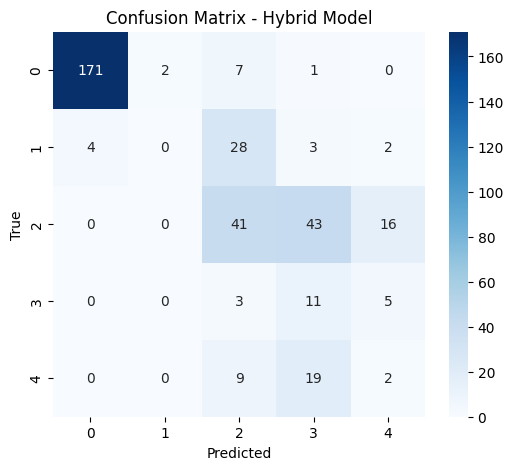

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow import keras

# ================== LOAD TEST DATA ==================
TEST_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/test_preprocess"

def load_test_ds(directory):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=["0","1","2","3","4"],
        color_mode="rgb",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    return ds

# ================== EVALUATE ==================
def evaluate_model(model_path, test_dir):
    print(f">> Load model từ {model_path}")
    model = keras.models.load_model(model_path)

    ds_test = load_test_ds(test_dir)

    # Lấy nhãn thật và dự đoán
    y_true = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
    y_pred_prob = model.predict(ds_test, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Tính metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec  = recall_score(y_true, y_pred, average="macro")
    f1   = f1_score(y_true, y_pred, average="macro")

    print("\n=== Evaluation Results ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["0","1","2","3","4"],
                yticklabels=["0","1","2","3","4"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Hybrid Model")
    plt.show()

# ================== RUN ==================

evaluate_model("outputs_hybrid/hybrid_final.keras", TEST_DIR)


<>:63: SyntaxWarning: invalid escape sequence '\D'
<>:64: SyntaxWarning: invalid escape sequence '\D'
<>:63: SyntaxWarning: invalid escape sequence '\D'
<>:64: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_12420\405596073.py:63: SyntaxWarning: invalid escape sequence '\D'
  TEST_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"
C:\Users\tran1\AppData\Local\Temp\ipykernel_12420\405596073.py:64: SyntaxWarning: invalid escape sequence '\D'
  evaluate_model("D:\Diux\hoctap\DoAn\models\outputs_hybrid\hybrid_finetune.keras", TEST_DIR)


>> Load model từ D:\Diux\hoctap\DoAn\models\outputs_hybrid\hybrid_finetune.keras
Found 1253 files belonging to 5 classes.
79/79 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step

=== Accuracy: 0.5411 ===

=== Classification Report ===


d:\Diux\hoctap\DoAn\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Diux\hoctap\DoAn\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Diux\hoctap\DoAn\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0     0.6549    0.9474    0.7744       627
           1     0.0091    0.0317    0.0141        63
           2     0.0000    0.0000    0.0000       448
           3     0.3158    0.2500    0.2791        24
           4     0.7103    0.8352    0.7677        91

    accuracy                         0.5411      1253
   macro avg     0.3380    0.4129    0.3671      1253
weighted avg     0.3858    0.5411    0.4493      1253



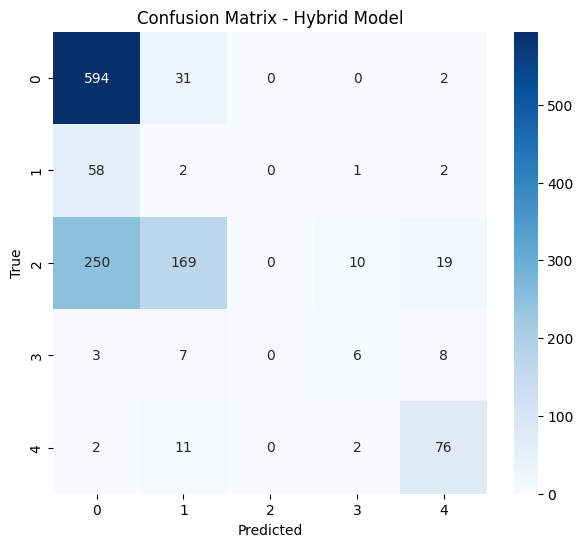

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
from tensorflow import keras
import tensorflow as tf

# ================== LOAD TEST DATA ==================
def load_test_ds(directory, img_size, batch_size):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=["0","1","2","3","4"],
        color_mode="rgb",
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False
    )
    return ds

# ================== EVALUATE ==================
def evaluate_model(model_path, test_dir, img_size=299, batch_size=16):
    print(f">> Load model từ {model_path}")
    model = keras.models.load_model(model_path)

    ds_test = load_test_ds(test_dir, img_size, batch_size)

    # Lấy nhãn thật dự đoán
    y_true = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
    y_pred_prob = model.predict(ds_test, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== Accuracy: {acc:.4f} ===\n")

    # Classification Report
    print("=== Classification Report ===")
    print(classification_report(
        y_true, y_pred,
        target_names=["0","1","2","3","4"],
        digits=4
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["0","1","2","3","4"],
                yticklabels=["0","1","2","3","4"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Hybrid Model")
    plt.show()

# ================== RUN ==================

TEST_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"
evaluate_model("D:\Diux\hoctap\DoAn\models\outputs_hybrid\hybrid_finetune.keras", TEST_DIR)


In [2]:
!ipynb-py-convert structure_model_vgg16_inceptionV3.ipynb structure_model_vgg16_inceptionV3.py

In [1]:
!ipynb-py-convert structure_model_vgg16_inceptionV3.ipynb vgg16_inceptionV3.py